# Benchmarking performance of DiPrimeFlip

This notebook can be used to replicate the experiments to compare the performance of DiPriMeFlip against various other tree-based methods.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as rn
import random
import pandas as pd
import csv
import os
from sklearn.model_selection import train_test_split
from scipy.stats import t as student_t
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../Classes")
sys.path.append("../Baselines")

In [2]:
# Function to generate dictionary of attribute ranges/values 
## X: Data (M points x N features) (M,N) numpy
## cat_idx: List of categorical feature indices
def gen_attdict(X,cat_idx):
    A = dict()
    for j in range(np.shape(X)[1]):
        if j in cat_idx:
            A[j] = list(np.unique(X[:,j]))
        else:
            A[j] = np.array([np.amin(X[:,j]),np.amax(X[:,j])])
    return A

In [3]:
# Function to compute suitable depth of tree for tree based on number of samples and desired minimum leaf node occupancy.
# The computation is done assuming that we learn balanced binary trees.
# num_samples: Number of samples
# min_occupacny: Desired minimum leaf node occupacny
# num_bins: Number of children per node
# partition: True if algorithm is trained on disjoint subsets of data
# num_trees: Number of trees trained
def tree_depth(num_samples, min_occupancy, num_bins=2, partition=False, num_trees=None):
    if partition and num_trees is None:
        raise ValueError("Need to specifiy number of trees if data is partitioned")
    if not partition:  # Each tree is trained on all the samples
        d = np.floor(np.log(num_samples/min_occupancy)/np.log(num_bins))
    else:  # Each tree is trained on a disjoint subset of the samples
        d = np.floor(np.log(num_samples/(min_occupancy*num_trees))/np.log(num_bins))
    return int(d)

In [4]:
# Function to determine uncertainty in results (error or accuracy) using Student's t-distribution.
# error_arr: (N_a, N_r) 2D numpy array of error/accuracy values, N_r is the number of runs for each algorithm
# algo_names: List of lenght N_a of algorithm names
# conf: % confidence interval
# This function prints the result to console and returns None.
def find_errors_with_bars(error_arr, algo_names, conf=0.95):
    if np.shape(error_arr)[0] != len(algo_names):
        raise ValueError('Number of rows of error_arr should match number of algorithms.')
    for i in range(np.shape(error_arr)[0]):
        error_mean = np.mean(error_arr[i])
        error_conf = student_t.interval(0.95, df=num_runs-1, loc=0, scale=np.std(error_arr[i])/np.sqrt(num_runs))[1]
        print('Error for ', algo_names[i], ' is ', error_mean, '+/-',error_conf)

## Regression:

In [5]:
from DiPrime import *
from DiPrimeFlip import *
from RandForest_DP import *
from dprf_Reg import DPRF_Reg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

num_runs = 5  # Number of runs for each method
algo_names = ['Random forest', 'ERT', 'Median trees', 'DP-RF', 'DiPriMe', 'DiPriMeFlip', 'DP Random Trees']

### Parkinson's Telemonitoring
This dataset has 5875 data points, with 26 attributes. We drop the subject# and motor UPDRS (another possible target). Only the sex attribute is categorical. The total UPDRS is taken as the target variable.

Link: https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring 

#### Read data:

In [40]:
data_path = "../Datasets/Parkinsons_Telemonitoring/parkinsons_updrs.data"
df_raw = pd.read_csv(data_path).drop(columns=['subject#','motor_UPDRS'])
attribute_names = df_raw.columns[:-1]
df_y = df_raw.pop('total_UPDRS')
df_raw['total_UPDRS'] = df_y

df = pd.DataFrame()
for col in df_raw.columns:
    if col not in ['sex','total_UPDRS']:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
    elif col != 'total_UPDRS':
        df[col] = df_raw[col]
df['total_UPDRS'] = df_raw['total_UPDRS']/df_raw['total_UPDRS'].max()

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

In [44]:
err_arr = np.zeros((7, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = [1]
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = np.copy(bnds_y)

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)

    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    rf = RandomForestRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
    err_arr[0, r] = err_rf

    rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum((y_tst-y_base)**2/len(y_tst))
    err_arr[1, r] = err_base

    mf = DiPrimeForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = mf.predict(X_tst,cat_idx)
    err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
    err_arr[2, r] = err_mf

    dprf = DPRF_Reg(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=10)
    y_dprf = dprf.predict(X_tst_cat)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[3, r] = err_dprf

    dpmf = DiPrimeForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpmf = dpmf.predict(X_tst,cat_idx)
    err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
    err_arr[4, r] = err_dpmf

    dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpdmf = dpdmf.predict(X_tst,cat_idx)
    err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
    err_arr[5, r] = err_dpdmf

    dprf = DPRandForest(n_trees=10,max_depth=d_full,max_features=1)
    dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
    y_dprf = dprf.predict(X_tst,cat_idx)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[6, r] = err_dprf

100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


In [45]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  Random forest  is  0.015875300984921993 +/- 0.0011025902919289136
Error for  ERT  is  0.027177478346181318 +/- 0.0015613735694329292
Error for  Median trees  is  0.020298750863891362 +/- 0.0015047028269893562
Error for  DP-RF  is  0.05214211747752181 +/- 0.024775406785690846
Error for  DiPriMe  is  0.034538659023242144 +/- 0.0011838019614840158
Error for  DiPriMeFlip  is  0.034127071256853665 +/- 0.0008969051023975686
Error for  DP Random Trees  is  0.03592943343275815 +/- 0.002242755652471132


### Appliances Energy Prediction
The appliances energy prediction dataset has 19,375 data instances  with 29 attributes. rv1 and rv2 are dropped, while the month and day are extracted from the date. The appliances (energy) value is taken as the target variable.

Link: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

#### Read data:

In [46]:
from datetime import date, datetime

data_path = "../Datasets/Appliances_Energy_Prediction/energydata_complete.csv"
df_raw = pd.read_csv(data_path)
Mp,Np = df_raw.shape

df_raw['Month'] = pd.Series([(datetime.strptime(df_raw.at[i,'date'],"%Y-%m-%d %H:%M:%S")
                                                         ).month for i in range(Mp)])
df_raw['Day'] = pd.Series([(datetime.strptime(df_raw.at[i,'date'],"%Y-%m-%d %H:%M:%S")
                                                         ).day for i in range(Mp)])
del df_raw['date'], df_raw['rv1'], df_raw['rv2']
print(df_raw.columns)

df_y = df_raw.pop('Appliances')
df_raw['Appliances'] = df_y

df = pd.DataFrame()
for col in df_raw.columns:
    if col not in ['Month','Appliances']:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
    elif col != 'Appliances':
        df[col] = df_raw[col]
        
y_min, y_max = df_raw['Appliances'].min(),df_raw['Appliances'].max()
df['Appliances'] = (df_raw['Appliances']-y_min)/(y_max-y_min)

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'Month', 'Day'],
      dtype='object')


In [49]:
err_arr = np.zeros((7, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = [25]
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = np.copy(bnds_y)

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)

    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    rf = RandomForestRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
    err_arr[0, r] = err_rf

    from sklearn.ensemble import ExtraTreesRegressor
    rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum((y_tst-y_base)**2/len(y_tst))
    err_arr[1, r] = err_base

    mf = DiPrimeForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = mf.predict(X_tst,cat_idx)
    err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
    err_arr[2, r] = err_mf

    dprf = DPRF_Reg(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=10)
    y_dprf = dprf.predict(X_tst_cat)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[3, r] = err_dprf

    dpmf = DiPrimeForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpmf = dpmf.predict(X_tst,cat_idx)
    err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
    err_arr[4, r] = err_dpmf

    dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpdmf = dpdmf.predict(X_tst,cat_idx)
    err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
    err_arr[5, r] = err_dpdmf

    dprf = DPRandForest(n_trees=10,max_depth=d_full,max_features=1)
    dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
    y_dprf = dprf.predict(X_tst,cat_idx)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[6, r] = err_dprf

100%|██████████| 5/5 [00:52<00:00, 10.51s/it]


In [50]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  Random forest  is  0.006234960280094335 +/- 0.0005703338015824468
Error for  ERT  is  0.0071218044837535275 +/- 0.0006173100259438422
Error for  Median trees  is  0.006147401815016837 +/- 0.00046798815763325207
Error for  DP-RF  is  0.03643505267927325 +/- 0.011352528516494133
Error for  DiPriMe  is  0.008672864702730335 +/- 0.0005700856819984647
Error for  DiPriMeFlip  is  0.008687256298032266 +/- 0.000592155752070818
Error for  DP Random Trees  is  0.008790259110224108 +/- 0.0005676927467271811


### Metro Interstate Traffic Volume

This is a UCI dataset logging the Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301. The features include weather-related features, date and holiday information. The traffic volume is the target variable with approximately 48,000 instances in the data.

Link: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [6]:
from datetime import date, datetime

data_path = "../Datasets/Metro_Interstate_Traffic_Volume/Metro_Interstate_Traffic_Volume.csv"
df_raw = pd.read_csv(data_path)
Mp,Np = df_raw.shape

df_raw['weekday'] = pd.Series([(datetime.strptime(df_raw.at[i,'date_time'],"%Y-%m-%d %H:%M:%S")
                               ).weekday() for i in range(Mp)])
df_raw['hour'] = pd.Series([(datetime.strptime(df_raw.at[i,'date_time'],"%Y-%m-%d %H:%M:%S")
                            ).hour for i in range(Mp)])
del df_raw['date_time'], df_raw['weather_description']

df_raw['holiday'] = pd.Categorical(df_raw.holiday)
df_raw['holiday'] = df_raw['holiday'].cat.codes
df_raw['weather_main'] = pd.Categorical(df_raw.weather_main)
df_raw['weather_main'] = df_raw['weather_main'].cat.codes

df_y = df_raw.pop('traffic_volume')
df_raw['traffic_volume'] = df_y

df = pd.DataFrame()
for col in df_raw.columns:
    if col not in ['holiday', 'weather_main', 'weekday']:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
    elif col != 'traffic_volume':
        df[col] = df_raw[col]
df['traffic_volume'] = (df_raw['traffic_volume'] - df_raw['traffic_volume'].min()
                       )/(df_raw['traffic_volume'].max() - df_raw['traffic_volume'].min())
print(df.columns)

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weekday', 'hour', 'traffic_volume'],
      dtype='object')


In [7]:
err_arr = np.zeros((7, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = [0, 5, 6]
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = np.copy(bnds_y)

## Train test split
train_size = int(np.floor(0.9*Xycat.shape[0]))
test_size = Xycat.shape[0]-train_size
shuffle_idx = rn.permutation(Xycat.shape[0])
train_idx = shuffle_idx[:train_size]
test_idx = shuffle_idx[train_size:]

X_tr = Xy[train_idx,:-1]
X_tst = Xy[test_idx,:-1]
y_tr = Xy[train_idx,-1]
y_tst = Xy[test_idx,-1]

M,N = np.shape(X_tr)


X_tr_cat = Xcat[train_idx,:]
X_tst_cat = Xcat[test_idx,:]
y_tr = y[train_idx]
y_tst = y[test_idx]

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)

    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    rf = RandomForestRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
    err_arr[0, r] = err_rf

    from sklearn.ensemble import ExtraTreesRegressor
    rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum((y_tst-y_base)**2/len(y_tst))
    err_arr[1, r] = err_base

    mf = DiPrimeForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = mf.predict(X_tst,cat_idx)
    err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
    err_arr[2, r] = err_mf

    dprf = DPRF_Reg(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=10)
    y_dprf = dprf.predict(X_tst_cat)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[3, r] = err_dprf

    dpmf = DiPrimeForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpmf = dpmf.predict(X_tst,cat_idx)
    err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
    err_arr[4, r] = err_dpmf

    dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpdmf = dpdmf.predict(X_tst,cat_idx)
    err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
    err_arr[5, r] = err_dpdmf

    dprf = DPRandForest(n_trees=10,max_depth=d_full,max_features=1)
    dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
    y_dprf = dprf.predict(X_tst,cat_idx)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[6, r] = err_dprf

100%|██████████| 5/5 [21:52<00:00, 262.56s/it]


In [8]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  Random forest  is  0.004885601513325716 +/- 0.0003573031560039744
Error for  ERT  is  0.006238034062108875 +/- 0.0009081280114097161
Error for  Median trees  is  0.006898454418191533 +/- 0.0004906278018769833
Error for  DP-RF  is  0.0331327277485579 +/- 0.005579835934440322
Error for  DiPriMe  is  0.029900449836239275 +/- 0.00454962839579382
Error for  DiPriMeFlip  is  0.027179872725845017 +/- 0.008046707804695933
Error for  DP Random Trees  is  0.04953420372355448 +/- 0.0031928560914107314


### Gas Turbine Emission
This UCI dataset contains 36733 instances of 11 sensor measures aggregated over one hour, from a gas turbine located in Turkey for the purpose of studying flue CO and NOx emissions.

Link: https://archive.ics.uci.edu/ml/datasets/Gas+Turbine+CO+and+NOx+Emission+Data+Set

In [9]:
data_path = "../Datasets/Gas_Turbine_Emission"
df_raw = pd.DataFrame()
for fname in os.listdir(data_path):
    df_raw = df_raw.append(pd.read_csv(data_path + '/'+ fname))

df_y = df_raw.pop('TEY')
df_raw['TEY'] = df_y

df = pd.DataFrame()
for col in df_raw.columns:
    if col != 'TEY':
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
df['TEY'] = (df_raw['TEY'] - df_raw['TEY'].min()
                       )/(df_raw['TEY'].max() - df_raw['TEY'].min())

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

#### Fitting models:

In [10]:
err_arr = np.zeros((7, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = []
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = np.copy(bnds_y)

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)

    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    rf = RandomForestRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
    err_arr[0, r] = err_rf

    rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum((y_tst-y_base)**2/len(y_tst))
    err_arr[1, r] = err_base

    mf = DiPrimeForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = mf.predict(X_tst,cat_idx)
    err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
    err_arr[2, r] = err_mf

    dprf = DPRF_Reg(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=10)
    y_dprf = dprf.predict(X_tst_cat)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[3, r] = err_dprf

    dpmf = DiPrimeForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpmf = dpmf.predict(X_tst,cat_idx)
    err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
    err_arr[4, r] = err_dpmf

    dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpdmf = dpdmf.predict(X_tst,cat_idx)
    err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
    err_arr[5, r] = err_dpdmf

    dprf = DPRandForest(n_trees=10,max_depth=d_full,max_features=1)
    dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
    y_dprf = dprf.predict(X_tst,cat_idx)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[6, r] = err_dprf

100%|██████████| 5/5 [01:08<00:00, 13.67s/it]


In [11]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  Random forest  is  0.00012283725653363195 +/- 6.813088192893463e-06
Error for  ERT  is  0.00023695652240271638 +/- 2.1674463293371267e-05
Error for  Median trees  is  0.00011372027599618993 +/- 8.304658718803452e-06
Error for  DP-RF  is  0.01852635478535352 +/- 0.009675508379023368
Error for  DiPriMe  is  0.0008703275040556815 +/- 0.00014018304004110465
Error for  DiPriMeFlip  is  0.0008708293336148077 +/- 8.196995329748872e-05
Error for  DP Random Trees  is  0.0036171175671756914 +/- 0.0015483785276119498


### Flight Delay

This is flight data taken from Jan to Apr 2008 with the month, day, weekday, departure time, arrival time, delay, air time and distance as features. The delay is the target variable. 80,000 instances are randomly sampled from this data.

Link: https://www.transtats.bts.gov/tables.asp?Table_ID=236&SYS_Table_Name=T_ONTIME_REPORTING

In [12]:
data_path = "../Datasets/Flight_Delay/"
fname = ['Jan2008.csv','Feb2008.csv','Mar2008.csv','Apr2008.csv']

col_names = ['Month','Day','Weekday','Dep Time','Arr Time',
                                                  'Delay','Air Time','Distance']
df_raw = pd.DataFrame()
for f in fname:
    df = pd.read_csv(data_path+f,names=col_names,header=0,usecols=[0,1,2,3,4,5,6,7])
    df_raw = df_raw.append(df)
df_raw = df_raw.dropna()
Md,Nd = df_raw.shape

df_raw = df_raw.iloc[random.sample(range(Md),800000)]
#print(df_raw.shape)

X = df_raw.drop(columns='Delay').to_numpy()
y = df_raw['Delay'].to_numpy()
y = (y - np.amin(y))/(np.amax(y)-np.amin(y))

df_y = df_raw.pop('Delay')
df_raw['Delay'] = df_y

df = pd.DataFrame()
for col in df_raw.columns:
    if col not in ['Month','Weekday','Delay']:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
    elif col != 'Delay':
        df[col] = df_raw[col]

y_min, y_max = df_raw['Delay'].min(),df_raw['Delay'].max()
df['Delay'] = (df_raw['Delay']-y_min)/(y_max-y_min)

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

#### Fitting models:

In [14]:
err_arr = np.zeros((7, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = [0,2]
A = gen_attdict(X_tr,cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(X_tr_cat,list(range(X_tr_cat.shape[1])))
C = np.copy(bnds_y)

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)

    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    rf = RandomForestRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum((y_tst-y_rf)**2/len(y_tst))
    err_arr[0, r] = err_rf

    from sklearn.ensemble import ExtraTreesRegressor
    rf_base = ExtraTreesRegressor(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum((y_tst-y_base)**2/len(y_tst))
    err_arr[1, r] = err_base

    mf = DiPrimeForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = mf.predict(X_tst,cat_idx)
    err_mf = np.sum((y_tst-y_mf)**2/len(y_tst))
    err_arr[2, r] = err_mf

    dprf = DPRF_Reg(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=10)
    y_dprf = dprf.predict(X_tst_cat)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[3, r] = err_dprf

    dpmf = DiPrimeForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpmf = dpmf.predict(X_tst,cat_idx)
    err_dpmf = np.sum((y_tst-y_dpmf)**2/len(y_tst))
    err_arr[4, r] = err_dpmf

    dpdmf = DiPrimeFlipForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=10,b_med=0.5)
    y_dpdmf = dpdmf.predict(X_tst,cat_idx)
    err_dpdmf = np.sum((y_tst-y_dpdmf)**2/len(y_tst))
    err_arr[5, r] = err_dpdmf

    dprf = DPRandForest(n_trees=10,max_depth=d_full,max_features=1)
    dprf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=20)
    y_dprf = dprf.predict(X_tst,cat_idx)
    err_dprf = np.sum((y_tst-y_dprf)**2/len(y_tst))
    err_arr[6, r] = err_dprf

100%|██████████| 5/5 [24:11<00:00, 290.38s/it]


In [15]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  Random forest  is  0.000489645675588011 +/- 1.2422082749878189e-05
Error for  ERT  is  0.0005057589716656512 +/- 1.1892791842028225e-05
Error for  Median trees  is  0.0005174712274387211 +/- 9.466412343053723e-06
Error for  DP-RF  is  0.03850411534993049 +/- 0.0041857962012694355
Error for  DiPriMe  is  0.0005687288594693099 +/- 1.0409890846649552e-05
Error for  DiPriMeFlip  is  0.0005658002244298842 +/- 1.180909077400652e-05
Error for  DP Random Trees  is  0.000583934645563215 +/- 1.2306622785694772e-05


## Classification:

In [5]:
from DP_DF.DP_SysFor import DP_SysFor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from DiPrime_Class import *
from DiPrimeFlip_Class import *
from RandForest_DP_Class import *
from dprf import DPRF

num_runs = 5  # Number of runs for each method
algo_names = ['DP-DF', 'DP-RF', 'Random forest', 'ERT', 'Median trees', 'DiPriMe', 'DiPriMeFlip', 'DP Random Trees']

### Banknote Authentication
This is a small dataset (1372 data points, 5 attributes) where all the attributes are real-valued with a binary target variable. 

Link: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

#### Read data:

In [6]:
data_path = "../Datasets/Banknote_Authentication/data_banknote_authentication.txt"
df_raw = pd.read_csv(data_path,index_col=False,
                     names=['variance','skewness','curtosis','entropy','class'])
attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col != 'class':
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
df['class'] = df_raw['class']

Xycat = df.to_numpy()
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

#### Fitting models:

In [7]:
err_arr = np.zeros((8, num_runs))
min_occ = 10  # Min leaf node occupancy

cat_idx = []
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)

    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst = list(y[test_idx])

    dpdf = DP_SysFor(records=Xycat_tr, max_height = d_mult, target_attribute_index=4, num_trees=10, 
                     epsilon_budget=1.0,attribute_names=attribute_names)
    y_pred = dpdf.classify_list(Xcat_tst)
    y_diff = [y_pred[i] != y_tst[i] for i in range(len(y_tst))]
    err_dpdf = sum(y_diff)/len(y_tst)
    err_arr[0, r] = err_dpdf
    
    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    dprf = DPRF(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=2)
    y_dprf = dprf.predict(X_tst_cat,C)
    err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
    err_arr[1, r] = err_dprf

    rf = RandomForestClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=4)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
    err_arr[2, r] = err_rf

    rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=4)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
    err_arr[3, r] = err_base

    mf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=4,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
    err_arr[4, r] = err_mf

    dpmf = DiPrimeCForest(n_trees=10,max_depth=d_part,max_features=4)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
    err_arr[5, r] = err_dpmf

    dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=d_part,max_features=4)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
    err_arr[6, r] = err_dpdmf

    dperf = DPRandCForest(n_trees=10,max_depth=d_full,max_features=1)
    dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=4)
    y_dperf = dperf.predict(X_tst,cat_idx)
    err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
    err_arr[7, r] = err_dperf

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


In [8]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  DP-DF  is  0.45942028985507244 +/- 0.05534782594039439
Error for  DP-RF  is  0.16666666666666666 +/- 0.07484762941338322
Error for  Random forest  is  0.02318840579710145 +/- 0.01049287397548905
Error for  ERT  is  0.01884057971014493 +/- 0.015687790985515614
Error for  Median trees  is  0.013043478260869565 +/- 0.01547999649989193
Error for  DiPriMe  is  0.11594202898550725 +/- 0.031683696550853645
Error for  DiPriMeFlip  is  0.10724637681159421 +/- 0.03137558197103123
Error for  DP Random Trees  is  0.3269685963133631 +/- 0.014424723650974969


### Credit Card Default

This dataset has 30,000 instances with 24 attributes. The target variable is the attribute corresponding to the client defaulting on the payment.

Link: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

#### Read data:

In [21]:
data_path = "../Datasets/Credit_Card_Default/default_credit_card_clients.xls"
df_raw = pd.read_excel(data_path,index_col=0,skiprows=1)

attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col in ['LIMIT_BAL','AGE','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
            df[col] = pd.cut(df_raw[col],bins=5,labels=False)
    elif col != 'default payment next month':
        df[col] = df_raw[col]

df['target'] = df_raw['default payment next month']

Xycat = df.to_numpy(np.float)
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy()

#### Fitting models:

In [23]:
err_arr = np.zeros((8, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = [1,2,3]
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]
    
    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)    

    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst = list(y[test_idx])

    dpdf = DP_SysFor(records=Xycat_tr, max_height = d_mult, target_attribute_index=23, num_trees=10, 
                     epsilon_budget=1.0,attribute_names=attribute_names, pruning=True)
    y_pred = dpdf.classify_list(Xcat_tst)
    y_diff = [y_pred[i] != y_tst[i] for i in range(len(y_tst))]
    err_dpdf = sum(y_diff)/len(y_tst)

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    err_arr[0, r] = err_dpdf

    dprf = DPRF(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=2)
    y_dprf = dprf.predict(X_tst_cat,C)
    err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
    err_arr[1, r] = err_dprf

    rf = RandomForestClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
    err_arr[2, r] = err_rf

    rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
    err_arr[3, r] = err_base

    mf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
    err_arr[4, r] = err_mf

    dpmf = DiPrimeCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
    err_arr[5, r] = err_dpmf

    dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
    err_arr[6, r] = err_dpdmf

    dperf = DPRandCForest(n_trees=10,max_depth=d_full,max_features=1)
    dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=4)
    y_dperf = dperf.predict(X_tst,cat_idx)
    err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
    err_arr[7, r] = err_dperf

100%|██████████| 5/5 [08:20<00:00, 100.11s/it]


In [24]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  DP-DF  is  0.22080000000000002 +/- 0.008358488386279457
Error for  DP-RF  is  0.20740000000000003 +/- 0.013936168851323672
Error for  Random forest  is  0.17446666666666666 +/- 0.009813946908631493
Error for  ERT  is  0.18513333333333332 +/- 0.01182184692555716
Error for  Median trees  is  0.21253333333333332 +/- 0.00858096732173202
Error for  DiPriMe  is  0.22080000000000002 +/- 0.008358488386279457
Error for  DiPriMeFlip  is  0.22080000000000002 +/- 0.008358488386279457
Error for  DP Random Trees  is  0.3262755258773102 +/- 0.006525245066458834


### Wall-Following Robot Navigation

This dataset has 5456 data instances with 24 attributes. The target variable is the last attribute binarized such that "move-forward" corresponds to 0 and all other values correspond to 1.

Link: https://archive.ics.uci.edu/ml/datasets/Wall-Following+Robot+Navigation+Data

#### Read data:

In [25]:
data_path = "../Datasets/Wall-Following_Robot_Nav/sensor_readings_24.data"
df_raw = pd.read_csv(data_path,index_col=False,header=None)
df = df_raw.copy()
df.loc[df_raw[24]=='Move-Forward',[24]] = 0 # Binarizing class
df.loc[df_raw[24]!='Move-Forward',[24]] = 1 # Binarizing class
df_raw = df.copy()

attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col != 24:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
df[24] = df_raw[24]

Xycat = df.to_numpy(np.float)
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]

In [30]:
err_arr = np.zeros((8, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = []
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)    

    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst = list(y[test_idx])

    dpdf = DP_SysFor(records=Xycat_tr, max_height=d_mult, target_attribute_index=24, num_trees=10,
                     attribute_names=attribute_names,pruning=True)
    y_pred = dpdf.classify_list(Xcat_tst)
    y_diff = [y_pred[i] != y_tst[i] for i in range(len(y_tst))]
    err_dpdf = sum(y_diff)/len(y_tst)

    Xy = df_raw.to_numpy(dtype=np.float)
    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    err_arr[0, r] = err_dpdf

    dprf = DPRF(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=2)
    y_dprf = dprf.predict(X_tst_cat,C)
    err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
    err_arr[1, r] = err_dprf

    rf = RandomForestClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
    err_arr[2, r] = err_rf

    rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
    err_arr[3, r] = err_base

    mf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=5, partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
    err_arr[4, r] = err_mf

    dpmf = DiPrimeCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
    err_arr[5, r] = err_dpmf

    dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
    err_arr[6, r] = err_dpdmf

    dperf = DPRandCForest(n_trees=10,max_depth=d_full,max_features=1)
    dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=4)
    y_dperf = dperf.predict(X_tst,cat_idx)
    err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
    err_arr[7,r] = err_dperf

100%|██████████| 5/5 [01:02<00:00, 12.60s/it]


In [31]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  DP-DF  is  0.40402930402930404 +/- 0.01611893194517562
Error for  DP-RF  is  0.26117216117216113 +/- 0.011379642237979853
Error for  Random forest  is  0.014285714285714287 +/- 0.006807152045084819
Error for  ERT  is  0.1413919413919414 +/- 0.03246167402321303
Error for  Median trees  is  0.05750915750915751 +/- 0.013989010951967812
Error for  DiPriMe  is  0.23663003663003662 +/- 0.024255276960475754
Error for  DiPriMeFlip  is  0.22380952380952382 +/- 0.024928227883351764
Error for  DP Random Trees  is  0.4122220572368766 +/- 0.006548432011306235


### HIGGS
There are 28 features, of which 7 are hand-crafted features. This dataset has 11 million samples, of which we sample 100,000 samples.

Link: https://archive.ics.uci.edu/ml/datasets/HIGGS#

In [32]:
data_path = "../Datasets/HIGGS/HIGGS_sampled.csv"
df_raw = pd.read_csv(data_path,index_col=False, header=None)
df_y = df_raw.pop(0)
df_raw[29] = df_y
attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col != 29:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
df[29] = df_raw[29]

Xycat = df.to_numpy(np.float)
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy(dtype=np.float)

In [34]:
err_arr = np.zeros((8, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = []
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)    

    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst = list(y[test_idx])

    dpdf = DP_SysFor(records=Xycat_tr, max_height=d_mult, target_attribute_index=28, num_trees=10,
                     attribute_names=attribute_names, pruning=True)
    y_pred = dpdf.classify_list(Xcat_tst)
    y_diff = [y_pred[i] != y_tst[i] for i in range(len(y_tst))]
    err_dpdf = sum(y_diff)/len(y_tst)

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    err_arr[0, r] = err_dpdf

    dprf = DPRF(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=2)
    y_dprf = dprf.predict(X_tst_cat,C)
    err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
    err_arr[1, r] = err_dprf

    rf = RandomForestClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
    err_arr[2, r] = err_rf

    rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
    err_arr[3, r] = err_base

    mf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
    err_arr[4, r] = err_mf

    dpmf = DiPrimeCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
    err_arr[5, r] = err_dpmf

    dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
    err_arr[6, r] = err_dpdmf

    dperf = DPRandCForest(n_trees=10,max_depth=d_full,max_features=1)
    dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=4)
    y_dperf = dperf.predict(X_tst,cat_idx)
    err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
    err_arr[7, r] = err_dperf

100%|██████████| 5/5 [38:20<00:00, 460.03s/it]


In [35]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  DP-DF  is  0.47056000000000003 +/- 0.0049045570756138905
Error for  DP-RF  is  0.46068 +/- 0.0047654022510108295
Error for  Random forest  is  0.30148 +/- 0.005340252364007852
Error for  ERT  is  0.35860000000000003 +/- 0.007048015606431878
Error for  Median trees  is  0.30732 +/- 0.004259034212362315
Error for  DiPriMe  is  0.39658000000000004 +/- 0.006869174325116135
Error for  DiPriMeFlip  is  0.39016 +/- 0.005066597734934428
Error for  DP Random Trees  is  0.4944157487301487 +/- 0.0011422681134706531


### PUC-Rio (Classification of body postures and movements)
There are 18 features and over 165,000 samples. The target is body posture with only samples corresponding to sitting or standing postures used.
Link: http://groupware.les.inf.puc-rio.br/har#ixzz2PyRdbAfA

In [36]:
data_path = "../Datasets/PUC-Rio/dataset-har-PUC-Rio-ugulino.csv"
df_raw = pd.read_csv(data_path, sep=';', index_col=False)
df_raw = df_raw.drop(columns=['user','body_mass_index'])
df_raw[df_raw['class'].str.contains('sitting')]['class'] = 'sitting'
df_raw[df_raw['class'].str.contains('standing')]['class'] = 'standing'
df_raw = df_raw.loc[(df_raw['class'] == 'sitting') | (df_raw['class'] == 'standing')]
df_raw['class'] = pd.Categorical(df_raw['class'])
df_raw['class'] = df_raw['class'].cat.codes  # Binarizing classes

df_raw['z4'] = df_raw['z4'].astype(np.int)
for col in df_raw.columns:
    if col in ['gender','age','how_tall_in_meters','weight']:
        df_raw[col] = pd.Categorical(df_raw[col])
        df_raw[col] = df_raw[col].cat.codes

attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col not in ['gender','age','how_tall_in_meters','weight','class']:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
    elif col != 'class':
        df[col] = df_raw[col]
df['class'] = df_raw['class']

Xycat = df.to_numpy(np.float)
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]
Xy = df_raw.to_numpy(dtype=np.float)

In [38]:
err_arr = np.zeros((8, num_runs))
min_occ = 25  # Min leaf node occupancy

cat_idx = [0, 1, 2, 3]
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

for r in tqdm(range(num_runs)):
    ## Train test split
    train_size = int(np.floor(0.9*Xycat.shape[0]))
    test_size = Xycat.shape[0]-train_size
    shuffle_idx = rn.permutation(Xycat.shape[0])
    train_idx = shuffle_idx[:train_size]
    test_idx = shuffle_idx[train_size:]

    d_full = tree_depth(train_size, min_occ)
    d_mult = tree_depth(train_size, min_occ, num_bins=5)
    d_part = tree_depth(train_size, min_occ, partition=True, num_trees=10)      
    
    Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
    Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
    y_tst = list(y[test_idx])

    dpdf = DP_SysFor(records=Xycat_tr, max_height=d_mult, target_attribute_index=16, num_trees=10,
                     attribute_names=attribute_names, pruning=True)
    y_pred = dpdf.classify_list(Xcat_tst)
    y_diff = [y_pred[i] != y_tst[i] for i in range(len(y_tst))]
    err_dpdf = sum(y_diff)/len(y_tst)

    X_tr = Xy[train_idx,:-1]
    X_tst = Xy[test_idx,:-1]
    y_tr = Xy[train_idx,-1]
    y_tst = Xy[test_idx,-1]

    M,N = np.shape(X_tr)

    X_tr_cat = Xcat[train_idx,:]
    X_tst_cat = Xcat[test_idx,:]
    y_tr = y[train_idx]
    y_tst = y[test_idx]

    err_arr[0, r] = err_dpdf

    dprf = DPRF(n_trees=10,max_depth=d_mult)
    dprf.fit(X_tr_cat,y_tr,Acat,C,eps=2)
    y_dprf = dprf.predict(X_tst_cat,C)
    err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)
    err_arr[1, r] = err_dprf

    rf = RandomForestClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf.fit(X_tr,y_tr)
    y_rf = rf.predict(X_tst)
    err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)
    err_arr[2, r] = err_rf

    rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
    rf_base.fit(X_tr,y_tr)
    y_base = rf_base.predict(X_tst)
    err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)
    err_arr[3, r] = err_base

    mf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=5,partition=False)
    mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
    y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)
    err_arr[4, r] = err_mf

    dpmf = DiPrimeCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)
    err_arr[5, r] = err_dpmf

    dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=d_part,max_features=5)
    dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
    y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
    err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)
    err_arr[6, r] = err_dpdmf

    dperf = DPRandCForest(n_trees=10,max_depth=d_full,max_features=1)
    dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=4)
    y_dperf = dperf.predict(X_tst,cat_idx)
    err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)
    err_arr[7, r] = err_dperf

100%|██████████| 5/5 [08:48<00:00, 105.63s/it]


In [39]:
find_errors_with_bars(err_arr, algo_names, 0.95)

Error for  DP-DF  is  0.4836853382307928 +/- 0.010512343633611379
Error for  DP-RF  is  0.012937455361697787 +/- 0.008284780081251926
Error for  Random forest  is  6.121824303642486e-05 +/- 6.206393689589382e-05
Error for  ERT  is  2.0406081012141617e-05 +/- 5.067499227441144e-05
Error for  Median trees  is  0.0 +/- nan
Error for  DiPriMe  is  0.0002448729721456994 +/- 0.00015202497682323434
Error for  DiPriMeFlip  is  0.00044893378226711555 +/- 0.0003061541306816317
Error for  DP Random Trees  is  0.2204418102298002 +/- 0.01723848193199512


### Examination of balancedness and node counts

We examine the balancedness of the splits with trees learned on the Wall-following Robot Navigation data.

In [25]:
data_path = "../Datasets/Wall-Following_Robot_Nav/sensor_readings_24.data"
df_raw = pd.read_csv(data_path,index_col=False,header=None)
df = df_raw.copy()
df.loc[df_raw[24]=='Move-Forward',[24]] = 0 # Binarizing class
df.loc[df_raw[24]!='Move-Forward',[24]] = 1 # Binarizing class
df_raw = df.copy()

attribute_names = df_raw.columns[:-1]

df = pd.DataFrame()
for col in df_raw.columns:
    if col != 24:
        df[col] = pd.cut(df_raw[col],bins=5,labels=False)
df[24] = df_raw[24]

Xycat = df.to_numpy(np.float)
Xcat = Xycat[:,:-1]
y = Xycat[:,-1]

In [30]:
min_occ = 25  # Min leaf node occupancy

cat_idx = []
A = gen_attdict(Xy[:,:-1],cat_idx) 
bnds_y = np.array([0,1]) # Bound on target value
Acat = gen_attdict(Xcat,list(range(Xcat.shape[1])))
C = [0,1]

## Train test split
train_size = int(np.floor(0.9*Xycat.shape[0]))
test_size = Xycat.shape[0]-train_size
shuffle_idx = rn.permutation(Xycat.shape[0])
train_idx = shuffle_idx[:train_size]
test_idx = shuffle_idx[train_size:]

d_full = 5    

Xycat_tr = [list(a) for a in list(Xycat[train_idx,:])]
Xcat_tst = [list(a) for a in list(Xycat[test_idx,:-1])]
y_tst = list(y[test_idx])

dpdf = DP_SysFor(records=Xycat_tr, max_height=d_full, target_attribute_index=24, num_trees=10,
                attribute_names=attribute_names,pruning=True)
y_pred = dpdf.classify_list(Xcat_tst)
y_diff = [y_pred[i] != y_tst[i] for i in range(len(y_tst))]
err_dpdf = sum(y_diff)/len(y_tst)

Xy = df_raw.to_numpy(dtype=np.float)
X_tr = Xy[train_idx,:-1]
X_tst = Xy[test_idx,:-1]
y_tr = Xy[train_idx,-1]
y_tst = Xy[test_idx,-1]

M,N = np.shape(X_tr)

X_tr_cat = Xcat[train_idx,:]
X_tst_cat = Xcat[test_idx,:]
y_tr = y[train_idx]
y_tst = y[test_idx]

dprf = DPRF(n_trees=10,max_depth=d_full)
dprf.fit(X_tr_cat,y_tr,Acat,C,eps=2)
y_dprf = dprf.predict(X_tst_cat,C)
err_dprf = np.sum(np.abs(y_tst-y_dprf))/len(y_tst)

rf = RandomForestClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
rf.fit(X_tr,y_tr)
y_rf = rf.predict(X_tst)
err_rf = np.sum(np.abs(y_rf-y_tst))/len(y_tst)

rf_base = ExtraTreesClassifier(n_estimators=10,max_depth=d_full,min_samples_leaf=5,max_features=5)
rf_base.fit(X_tr,y_tr)
y_base = rf_base.predict(X_tst)
err_base = np.sum(np.abs(y_tst-y_base))/len(y_tst)

mf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=5, partition=False)
mf.fit(X_tr,y_tr,A,cat_idx,bnds_y)
y_mf = (mf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
err_mf = np.sum(np.abs(y_tst-y_mf))/len(y_tst)

dpmf = DiPrimeCForest(n_trees=10,max_depth=d_full,max_features=5)
dpmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
y_dpmf = (dpmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
err_dpmf = np.sum(np.abs(y_tst-y_dpmf))/len(y_tst)

dpdmf = DiPrimeFlipCForest(n_trees=10,max_depth=d_full,max_features=5)
dpdmf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=2,b_med=0.5)
y_dpdmf = (dpdmf.predict(X_tst,cat_idx) >= 0.5).astype(np.float)
err_dpdmf = np.sum(np.abs(y_tst-y_dpdmf))/len(y_tst)

dperf = DPRandCForest(n_trees=10,max_depth=d_full,max_features=1)
dperf.fit(X_tr,y_tr,A,cat_idx,bnds_y,eps=4)
y_dperf = dperf.predict(X_tst,cat_idx)
err_dperf = np.sum(np.abs(y_tst-y_dperf))/len(y_tst)

100%|██████████| 5/5 [01:02<00:00, 12.60s/it]


In [172]:
node_count_avg = 0
for tree in dpdf._forest:
    node_list = [tree._root_node]
    node_count = 0
    while node_list:
        node_count += 1
        curr_node = node_list.pop(0)
        if curr_node._children is not None:
            node_list.extend(curr_node._children)
    node_count_avg += node_count
print('Average node count for DPDF: ',node_count_avg/len(dpdf._forest))

Average node count for DPDF:  267.0


In [173]:
node_count_avg = 0
for tree in dprf.trees:
    node_list = [tree]
    node_count = 0
    while node_list:
        node_count += 1
        curr_node = node_list.pop(0)
        if curr_node.children:
            node_list.extend(curr_node.children)
    node_count_avg += node_count
print('Average node count for DPRF: ',node_count_avg/len(dprf.trees))

Average node count for DPRF:  1959.0


##### Checking balancedness of trees

In [174]:
leaf_counts = []
for tree in dpdf._forest:
    node_list = [tree._root_node]
    while node_list:
        curr_node = node_list.pop(0)
        if curr_node._children is not None:
            node_list.extend(curr_node._children)
        else:
            #print(curr_node._attribute_name)
            leaf_counts.append(curr_node._count)
#print(leaf_counts)
leaf_counts = np.array(leaf_counts)
print('SD of leaf counts for DP-DF: ', np.std(leaf_counts)/np.mean(leaf_counts))
low_occ_dpdf = np.copy(leaf_counts)

SD of leaf counts for DP-DF:  5.584486966508668


In [175]:
leaf_counts = []
for tree in dprf.trees:
    node_list = [tree]
    while node_list:
        curr_node = node_list.pop(0)
        if curr_node.children:
            node_list.extend(curr_node.children)
        else:
            leaf_counts.append(curr_node.count)
#print(leaf_counts)
leaf_counts = np.array(leaf_counts)
print('SD of leaf counts for DP-RF: ', np.std(leaf_counts)/np.mean(leaf_counts))
low_occ_dprf = np.copy(leaf_counts)

SD of leaf counts for DP-RF:  8.434519885840492


In [176]:
leaf_counts = []
for tree in dperf.trees:
    node_list = [tree]
    while node_list:
        curr_node = node_list.pop(0)
        if curr_node.left is not None and curr_node.right is not None:
            node_list.extend([curr_node.left, curr_node.right])
        else:
            leaf_counts.append(curr_node.count)
#print(leaf_counts)
leaf_counts = np.array(leaf_counts)
print('SD of leaf counts for DP random tree: ', np.std(leaf_counts)/np.mean(leaf_counts))
low_occ_dperf = np.copy(leaf_counts)

SD of leaf counts for DP random tree:  6.8568174671315445


In [177]:
leaf_counts = []
for tree in dpmf.trees:
    node_list = [tree]
    while node_list:
        curr_node = node_list.pop(0)
        if curr_node.left is not None and curr_node.right is not None:
            node_list.extend([curr_node.left, curr_node.right])
        else:
            leaf_counts.append(curr_node.count)
#print(leaf_counts)
leaf_counts = np.array(leaf_counts)
print('SD of leaf counts for DiPriMe tree: ', np.std(leaf_counts)/np.mean(leaf_counts))
low_occ_dpmf = np.copy(leaf_counts)

SD of leaf counts for DP median tree:  0.620304920890169


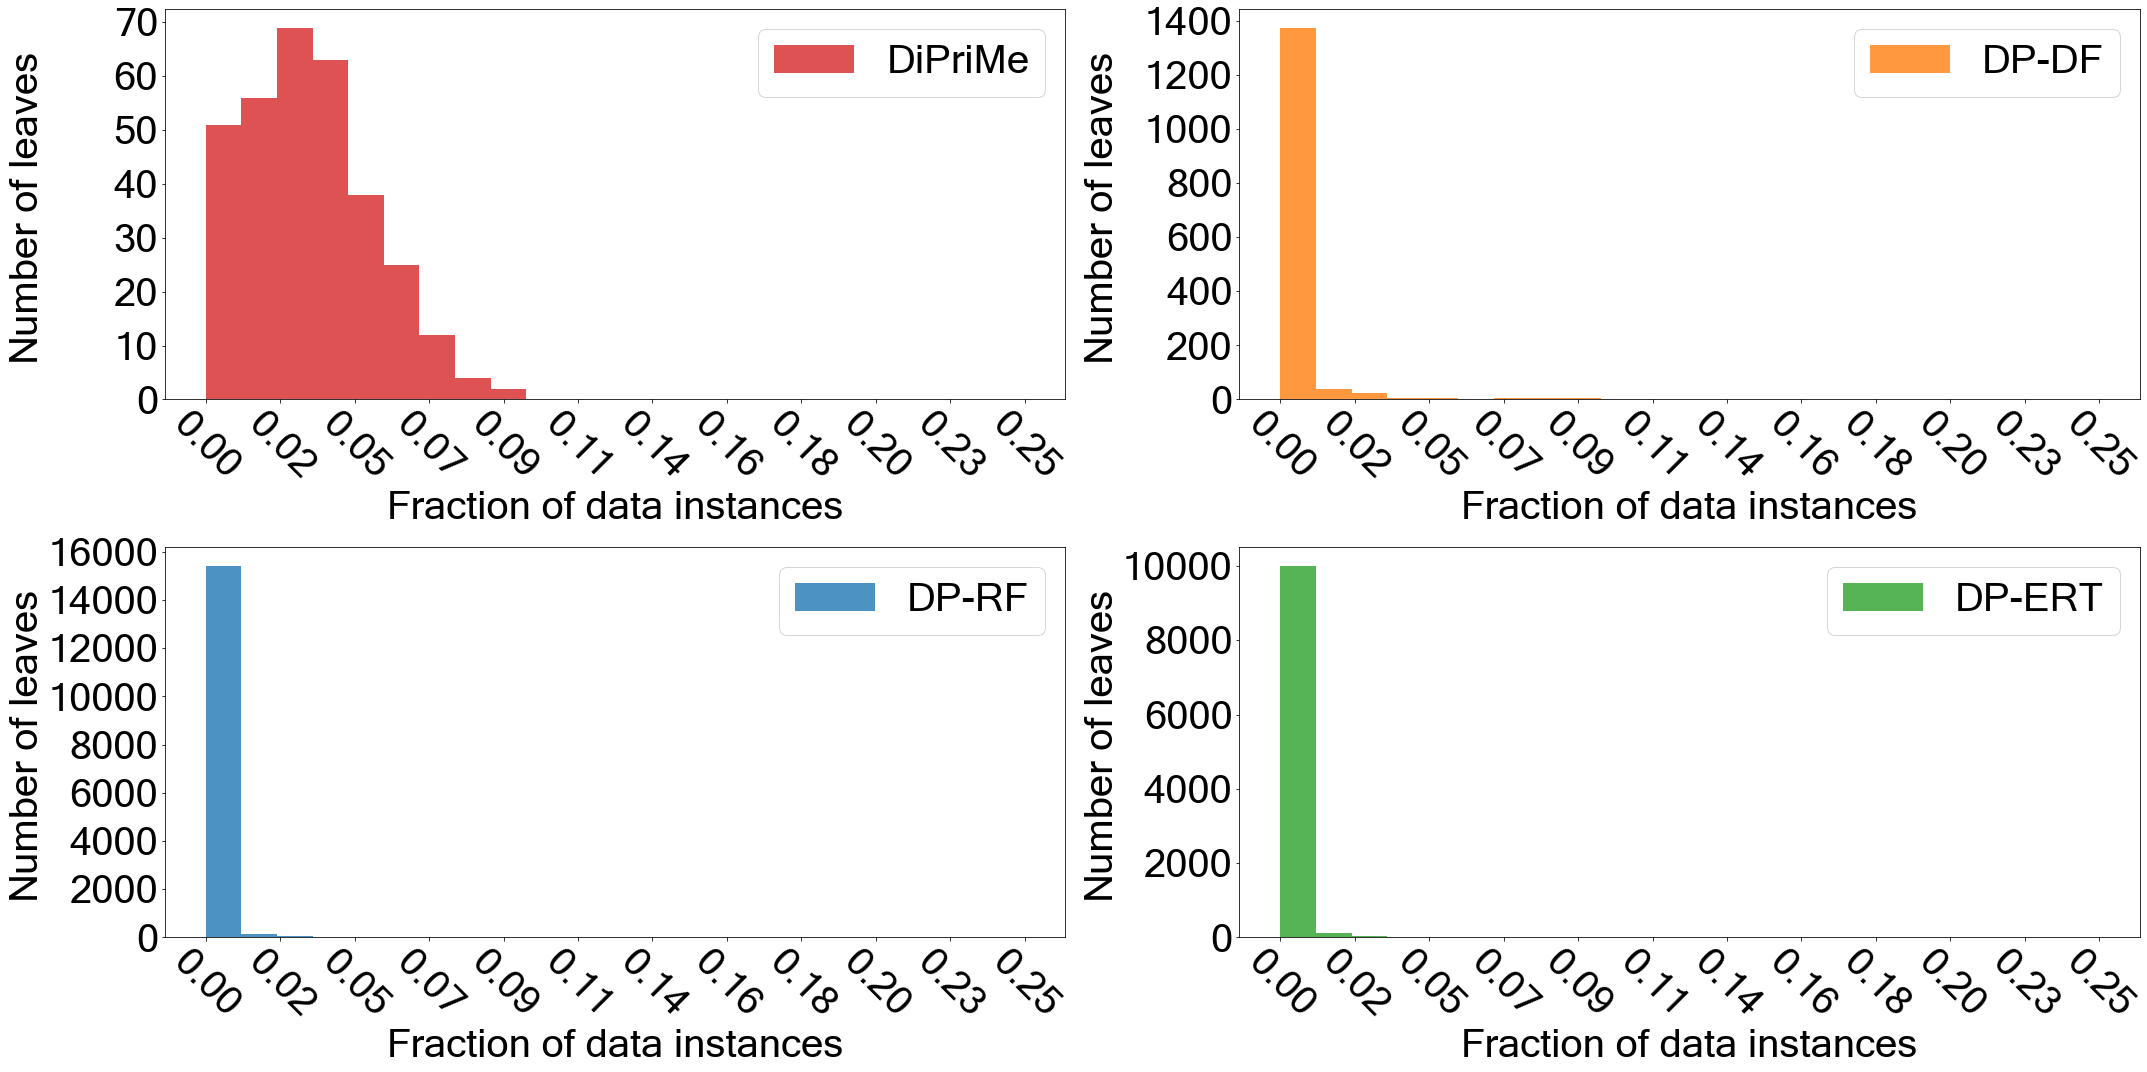

In [188]:
bins = np.linspace(0,len(y_tr)/4,24)
figx, figy = (2, 2)  # Configure subplot layout
label_angle = -45  # Angle of xlabels
plt.figure(figsize=(30,15))
plt.subplot(figx,figy,1)
counts,bins,_ = plt.hist(low_occ_dpmf,bins,density=False,color='tab:red',alpha=0.8,label='DiPriMe')

plt.legend(prop={'size':40,'family':'Microsoft Sans Serif'})
xticks = np.linspace(0,len(y_tr)/4,12)
xtick_labels = ["{:4.2f}".format(x) for x in xticks/len(y_tr)]
plt.xticks(xticks,labels=xtick_labels,rotation=label_angle)
plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.xlabel("Fraction of data instances",fontsize=40,fontname='Microsoft Sans Serif')
plt.ylabel("Number of leaves",fontsize=40,fontname='Microsoft Sans Serif')

plt.subplot(figx,figy,2)
counts,bins,_ = plt.hist(low_occ_dpdf,bins,density=False,color='tab:orange',alpha=0.8,label='DP-DF')

plt.legend(prop={'size':40,'family':'Microsoft Sans Serif'})
xticks = np.linspace(0,len(y_tr)/4,12)
xtick_labels = ["{:4.2f}".format(x) for x in xticks/len(y_tr)]
plt.xticks(xticks,labels=xtick_labels,rotation=label_angle)
plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.xlabel("Fraction of data instances",fontsize=40,fontname='Microsoft Sans Serif')
plt.ylabel("Number of leaves",fontsize=40,fontname='Microsoft Sans Serif')

plt.subplot(figx,figy,3)
counts,bins,_ = plt.hist(low_occ_dprf,bins,density=False,color='tab:blue',alpha=0.8,label='DP-RF')

plt.legend(prop={'size':40,'family':'Microsoft Sans Serif'})
xticks = np.linspace(0,len(y_tr)/4,12)
xtick_labels = ["{:4.2f}".format(x) for x in xticks/len(y_tr)]
plt.xticks(xticks,labels=xtick_labels,rotation=label_angle)
plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.xlabel("Fraction of data instances",fontsize=40,fontname='Microsoft Sans Serif')
plt.ylabel("Number of leaves",fontsize=40,fontname='Microsoft Sans Serif')

plt.subplot(figx,figy,4)
counts,bins,_ = plt.hist(low_occ_dperf,bins,density=False,color='tab:green',alpha=0.8,label='DP-ERT')

plt.legend(prop={'size':40,'family':'Microsoft Sans Serif'})
xticks = np.linspace(0,len(y_tr)/4,12)
xtick_labels = ["{:4.2f}".format(x) for x in xticks/len(y_tr)]
plt.xticks(xticks,labels=xtick_labels,rotation=label_angle)
plt.xticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.yticks(fontsize=40,fontname='Microsoft Sans Serif')
plt.xlabel("Fraction of data instances",fontsize=40,fontname='Microsoft Sans Serif')
plt.ylabel("Number of leaves",fontsize=40,fontname='Microsoft Sans Serif')

fig = plt.gcf()
fig.align_ylabels()
fig.tight_layout()
plt.savefig('DiPriMe_Results/node_occ.png',bbox_inches='tight')